In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import time
import random
from scipy.io import loadmat
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10
data = loadmat('ex4data1.mat')

In [3]:
X = data['X']
y = data['y']
X.shape,y.shape

((5000, 400), (5000, 1))

In [4]:
# =========== Part 1: Loading and Visualizing Data =============
m = len(X)
rand_indices = random.sample(np.arange(5000).tolist(), 100)
sel = X[rand_indices,:]

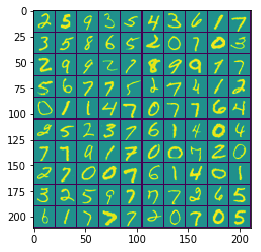

In [5]:
def displayData(X):
    #  实际就是把（100,400) ，每行转换成20*20 像素的小矩阵即一个数字，100行共100个数字
    example_width = int(round(np.sqrt(X.shape[1])))
    [m,n] = X.shape
    example_height = int(n / example_width)
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    pad = 1
    display_array = pd.DataFrame(-np.ones([pad + display_rows * (example_height + pad), pad + display_cols * \
                                           (example_width + pad)]))
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            max_val = max(abs(X[curr_ex,:]))
            display_array.iloc[pad + j*(example_height+pad) + np.arange(example_height),\
                         pad + i*(example_width+pad) + np.arange(example_width)] = \
            X[curr_ex,:].reshape(example_height, example_width).T / max_val  #  和 matlab的reshap不同，需要加转置
            curr_ex += 1
    plt.imshow(display_array)
displayData(sel)


In [6]:
# ================ Part 2: Loading Pameters ================
# 通过已有的权重参数验证下cost是否与文档中一样，以确保cost函数编写正确
weight = loadmat('ex4weights.mat')
Theta1 = weight['Theta1']
Theta2 = weight['Theta2']
nn_params = np.concatenate((Theta1.reshape(Theta1.shape[0] * Theta1.shape[1], 1), \
                            Theta2.reshape(Theta2.shape[0] * Theta2.shape[1], 1)), axis=0)

In [7]:
# ================ Part 3: Compute Cost (Feedforward) ================
def sigmoid(z):
    return 1 / (1 + np.exp(-z) )

$$ J_\Theta =  - \frac{1}{m} \left [ \sum_{i=1}^{m} \sum_{k=1}^{s_L}y_k^{(i)}log\left(h_{\Theta}(x^{(i)})\right)_k + (1-y_k^{(i)})log\left(1-\left(h_\Theta(x^{(i)})\right)_k\right) \right ] + \\ \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{j=1}^{s_l}\sum_{i=1}^{s_{l+1}}\left ( \Theta_{ij}^{(l)} \right)^2 \\ ,其中L为总层数，sl为每层神经元数。正则化忽略偏置项(j从1开始)  $$ 

In [9]:
def forward_propagation(X, y, Theta1, Theta2, num_labels):
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    E = np.eye(num_labels)
    ry = E[y.ravel()-1] #(5000,10)
    return z2, a2, z3, a3, ry

def regularized_cost(nn_params, X, y, lamda, input_layer_size=input_layer_size, hidden_layer_size=hidden_layer_size,\
                    num_labels=num_labels, m=m):
    Theta1 = nn_params[:(input_layer_size + 1) * hidden_layer_size].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:].reshape(num_labels, hidden_layer_size+1)  
    [z2, a2, z3, a3, ry] = forward_propagation(X, y, Theta1, Theta2, num_labels)
    cost = - (ry*np.log(a3) + (1-ry)*np.log(1-a3))
    J = cost.sum() / m + lamda/(2*m) * (np.square(Theta1[:,1:]).sum() + np.square(Theta2[:,1:]).sum())
    return J
# X = np.insert(X, 0, 1, axis=1)  # 输出函数的X要带有偏置项
J = regularized_cost(nn_params, X, y, 0)
print('Cost at parameters (loaded from ex4weights): %s ''\n(this value should be about 0.287629)\n'%J)

Cost at parameters (loaded from ex4weights): 0.2876291651613189 
(this value should be about 0.287629)



In [10]:
# =============== Part 4: Implement Regularization ===============
J = regularized_cost(nn_params, X, y, 1)
print('Cost at parameters (loaded from ex4weights): %s ''\n(this value should be about 0.383770\n'%J)

Cost at parameters (loaded from ex4weights): 0.38376985909092365 
(this value should be about 0.383770



In [15]:
#  ================ Part 5: Sigmoid Gradient  ================
def sigmoid_gradient(z):
    return sigmoid(z)*(1-sigmoid(z))
sigmoid_gradient(np.array([1, -0.5, 0, 0.5, 1]))

array([0.19661193, 0.23500371, 0.25      , 0.23500371, 0.19661193])

In [14]:
#  ================ Part 6: Initializing Pameters ================

 $\Theta^{l}$ should be in the range $[ -\epsilon_{init}, \epsilon_{init} ] $,
 a good choice of $\epsilon_{init}$  is $\epsilon_{init}$ = $\frac{\sqrt6}{\sqrt{ L_{in} + L_{out} }}$, where $L_{in}$ 
 =s_l and $L_{out}=s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$。$ \frac{\sqrt6} { \sqrt{401+25}} \approx 0.12$

In [11]:
def rand_initialize_weights(L_in, L_out):
    epsilon_init = 0.12
    weights = np.random.rand(L_out, L_in) * 2 * epsilon_init - epsilon_init
    return weights
initial_theta1 = rand_initialize_weights(input_layer_size+1, hidden_layer_size)
initial_theta2 = rand_initialize_weights(hidden_layer_size+1, num_labels)
initial_nn_params = np.concatenate((initial_theta1.ravel(), initial_theta2.ravel()), axis=0).reshape(-1, 1)

In [13]:
#  =============== Part 7: Implement Backpropagation ===============
def regularized_grad(nn_params, X, y, lamda, input_layer_size=input_layer_size, hidden_layer_size=hidden_layer_size,\
                    num_labels=num_labels, m=m):
    Theta1 = nn_params[:(input_layer_size + 1) * hidden_layer_size].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:].reshape(num_labels, hidden_layer_size+1)
    [z2, a2, z3, a3, ry] = forward_propagation(X, y, Theta1, Theta2, num_labels)
    delta3 = a3 - ry   # (5000,10)
    delta2 =delta3 @ Theta2[:,1:] * sigmoid_gradient(z2)   # (5000,25)
    Delta2 = delta3.T @ a2 #(10,26)
    Delta1 = delta2.T @ X  # (25, 401)
    Theta2_grad = Delta2 / m +  lamda/m * np.insert(Theta2[:,1:],0,0, axis=1)
    Theta1_grad = Delta1 / m +  lamda/m * np.insert(Theta1[:,1:],0,0, axis=1)
    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.shape[0] * Theta1_grad.shape[1], 1), \
                            Theta2_grad.reshape(Theta2_grad.shape[0] * Theta2_grad.shape[1], 1)), axis=0)
    return grad

In [25]:
def check_gradients(lamda):
    def debug_initial_weights(L_in, L_out):
        W = np.zeros((L_out, L_in))
        W = np.sin(range(1,W.size+1)).reshape(W.shape[1],W.shape[0]).T / 10  # reshape这么写为了跟matlab一致
        return W
    # 生成一个小的network检验
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    initial_theta1 = debug_initial_weights(input_layer_size+1, hidden_layer_size)
    initial_theta2 = debug_initial_weights(hidden_layer_size+1, num_labels)
    X = debug_initial_weights(input_layer_size, m)
    y = np.array([x%num_labels+1 for x in range(1,m+1)]).reshape(-1,1)
    nn_params = np.concatenate((initial_theta1.ravel(), initial_theta2.ravel()), axis=0).reshape(-1, 1)
    grad = regularized_grad(nn_params, np.insert(X, 0, 1, axis=1) , y, 0, input_layer_size, hidden_layer_size, num_labels, m)
    # numeric grad
    e = 1e-4
    numeric_grad = np.zeros((len(nn_params),1))
    for i in range(len(nn_params)):
        p = np.zeros((len(nn_params),1))
        p[i] = e
        plus_loss =  regularized_cost(nn_params+p, np.insert(X, 0, 1, axis=1) , y, lamda, input_layer_size, hidden_layer_size, num_labels, m)
        minus_loss =  regularized_cost(nn_params-p, np.insert(X, 0, 1, axis=1) , y, lamda, input_layer_size, hidden_layer_size, num_labels, m)
        numeric_grad[i] = (plus_loss - minus_loss) / (2*e)
    diff_grad = np.linalg.norm(grad - numeric_grad) /  np.linalg.norm(grad + numeric_grad)
    print('If your backpropagation implementation is correct, then \n' \
         'the relative difference will be small (less than 1e-9). \n' \
         '\nRelative Difference: %s\n' % diff_grad)
check_gradients(0)

If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9). 

Relative Difference: 2.534525809550779e-11



In [26]:
#  =============== Part 8: Implement Regularization ===============
check_gradients(2)

If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9). 

Relative Difference: 0.14904279442732923



In [268]:
#  =================== Part 8: Training NN ===================
res = opt.minimize(fun=regularized_cost,
                   x0=initial_nn_params,
                   args=(X, y, 5),
                   method='TNC',
                   jac=regularized_grad,
                   options={'maxiter': 400})
res

     fun: 0.722194281456199
     jac: array([[-1.12686686e-04],
       [-2.38286332e-08],
       [ 4.15406402e-08],
       ...,
       [ 1.05932657e-05],
       [-9.95063082e-05],
       [-6.96053006e-05]])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 26
  status: 3
 success: False
       x: array([ 4.52210648e-01, -2.38286332e-05,  4.15406402e-05, ...,
       -7.92867659e-01,  2.62328984e-01,  1.00292451e+00])

In [269]:
last_theta1 = res.x[:initial_theta1.size].reshape(initial_theta1.shape)
last_theta2 = res.x[initial_theta1.size:].reshape(initial_theta2.shape)
last_theta1.shape, last_theta2.shape

((25, 401), (10, 26))

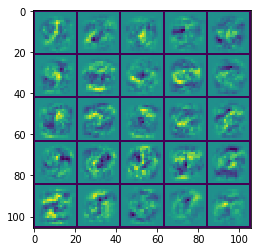

In [270]:
#  ================= Part 9: Visualize Weights =================
displayData(last_theta1[:,1:])

In [ ]:
#  ================= Part 10: Implement Predict =================

In [271]:
def predict(X, y, theta1, theta2 ):
    z2 = np.dot(X, theta1.T)
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)
    z3 = np.dot(a2, theta2.T)
    a3 = sigmoid(z3)
    pos = np.argmax(a3, axis=1).reshape(-1,1)+1
    accuracy = (y == pos).mean() * 100
    print(classification_report(y, pos1))
    return accuracy, a3
accuracy, a3 = predict(X, y, last_theta1, last_theta2)
accuracy

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       0.99      0.99      0.99       500
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      1.00      1.00       500
           8       1.00      1.00      1.00       500
           9       1.00      0.99      0.99       500
          10       1.00      1.00      1.00       500

   micro avg       1.00      1.00      1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



96.28

$
 本例中使用的激活函数为g(x)=sigmoid函数，损失函数使用的为逻辑回归的损失函数。\\
方便公式简便，只有一个样本进行偏导计算，假设network共L层。使用“\textstyle \bullet” 表示向量乘积运算符, \\
python中的numpy.multiply\\
\textbf{网络大致图}\\
\quad\Theta^1\quad\Theta^2\quad{\dots}\quad\Theta^{L-1}\\
\begin{bmatrix} 
a^1&a^2&a^3{\dots}a^{L-1}&a^{L}
\end{bmatrix}   \quad记：l=L-1 \\
输入层{\dots}隐藏层\quad{\dots}\quad输出层\\~\\
\textbf{链式求导法则}\\
若函数u =\omega(t) ,v = \psi(t)在t点可导z = f(u,v) 在点(u,v)处偏导连续，则复合函数z = f(\omega,\psi)\\
在t点可导，且有链式法则 \\ \frac{dz}{dt} = \frac{\partial z}{\partial u}·\frac{du}{dt} + \frac{\partial z}{\partial v}·\frac{dv}{dt} = \frac{\partial f}{\partial u}·\frac{du}{dt} + \frac{\partial f}{\partial v}·\frac{dv}{dt} = 
f'_1·\frac{du}{dt} + f'_2·\frac{dv}{dt}\\~\\
1 .对隐藏层到输出层 l 的\Theta_{ij}^{(l)} 求偏导 , s_l为l层的unit数\\
根据链式法则，可以假设\\
J = f(a_1^{l+1},a_2^{l+1}...a_{s_{l+1}}^{l+1})，a_i^{l+1}=g(z_i^{l+1})，z_i^{l+1}= \sum_{j=1}^{s_l} \Theta_{ij}^la_j^l  \\则
  \frac{\partial{J_{\Theta}}}{\partial\Theta_{ij}^{(l)}} = \frac{\partial f_1}{\partial a_1^{l+1}}\frac{\partial a_1^{l+1}}{\partial\Theta_{ij}^{(l)}}  +  \frac{\partial f_2}{\partial a_2^{l+1}}\frac{\partial a_2^{l+1}}{\partial\Theta_{ij}^{(l)}} +
  ...  + \frac{\partial f_{s_{l+1}}}{\partial a_{s_{l+1}}^{l+1}}\frac{\partial a_{s_{l+1}}^{l+1}}{\partial\Theta_{ij}^{(l)}} \\
  = f'_1 \frac{\partial g}{\partial z_1^{l+1}} \frac{\partial z_1^{l+1}}{\partial\Theta_{ij}^{(l)}}  + 
  f'_2 \frac{\partial g}{\partial z_2^{l+1}} \frac{\partial z_2^{l+1}}{\partial\Theta_{ij}^{(l)}}  + ... +
  f'_{s_{l+1}} \frac{\partial g}{\partial z_{s_{l+1}}^{l+1}} \frac{\partial z_{s_{l+1}}^{l+1}}{\partial\Theta_{ij}^{(l)}} \\
  =  f'_ig'(z_i^{l+1})\frac{\partial z_i^{l+1}}{\partial \Theta_{ij}^l} = \frac{\partial f_i}{\partial z_i^{l+1}}·\frac{\partial z_i^{l+1}}{\partial \Theta_{ij}^l}  \\
 =\frac{\partial}{\partial z_i^{l+1}}  \big(-y_ilog\left(h_{\Theta}(x)\right)_i - (1-y_i)log\left(1-\left(h_\Theta(x)\right)_i\right) \big)
 \frac{\partial z_i^{(l+1)}}{\partial\Theta_{ij}^{(l)}} ， 其中\left(h_\Theta{(x)}\right)_k = k^{th}output \\  记\delta_i^{l+1}=\frac{\partial}{\partial z_i^{l+1}}  \big(-y_ilog\left(h_{\Theta}(x)\right)_i - (1-y_i)log\left(1-\left(h_\Theta(x)\right)_i\right) \big)  , \beta= \frac{\partial z_i^{(l+1)}}{\partial\Theta_{ij}^{(l)}} 
$





$现在对第i个输出单元的残差进行求导 \\ \delta_i^{l+1}=\frac{\partial}{\partial z_i^{l+1}}  \big(-y_ilog\left(h_{\Theta}(x)\right)_i - (1-y_i)log\left(1-\left(h_\Theta(x)\right)_i\right) \big) \\
=\frac{\partial}{\partial a_i^{l+1}}  \big(-y_iloga_i^{l+1} - (1-y_i)log\left(1-a_i^{l+1}\right) \big) ·g'(z_i^{l+1})\\ = - \frac{y_i}{g(z_i^{l+1})}*g'(z_i^{l+1}) + \frac{(1-y_i)}{1-g(z_i^{l+1})}·g'(z_i^{l+1})
\\= - \frac{y_i}{g(z_i^{l+1})}·g(z_i^{l+1})(1-g(z_i^{l+1})) + \frac{(1-y_i)}{1-g(z_i^{l+1})}g(z_i^{l+1})(1-g(z_i^{l+1})) \\ 
= g(z_i^{l+1}) - y_i = a_i^{l+1} - y_i  \\ 
补充：如果用最小二乘法-线性回归的损失函数，则\delta_i^{l+1}=(a_i^{l+1} - y_i)g'(x)
\\ 
对第i个输出单元的第j个\beta进行求导\\  \beta= \frac{\partial z_i^{(l+1)}}{\partial\Theta_{ij}^{(l)}} = \frac{\partial}{\partial\Theta_{ij}^{(l)}}\sum_{n=1}^{s_{l}+1}a_n^l\Theta_{in}^{(l)} = \frac{\partial}{\partial\Theta_{ij}^{(l)}}a_j^l\Theta_{ij}^{(l)}  = a_j^l $

$
综上，用逻辑回归的损失函数对输出层的\Theta求导如下\\
\begin{bmatrix} 
\frac{\partial{J_{\Theta}}}{\partial\Theta_{10}^{(l)}}&\frac{\partial{J_{\Theta}}}{\partial\Theta_{11}^{(l)}}&...&\frac{\partial{J_{\Theta}}}{\partial\Theta_{1s_l}^{(l)}}  \\
 \frac{\partial{J_{\Theta}}}{\partial\Theta_{20}^{(l)}}&\frac{\partial{J_{\Theta}}}{\partial\Theta_{21}^{(l)}}&...&\frac{\partial{J_{\Theta}}}{\partial\Theta_{2s_l}^{(l)}} \\
 {\vdots}&{\vdots}&{\ddots}&{\vdots}\\
 \frac{\partial{J_{\Theta}}}{\partial\Theta_{s_{l+1}0}^{(l)}}&\frac{\partial{J_{\Theta}}}{\partial\Theta_{s_{l+1}1}^{(l)}}&...&\frac{\partial{J_{\Theta}}}{\partial\Theta_{s_{l+1}s_l}^{(l)}} 
\end{bmatrix} = 
\begin{bmatrix} 
\delta_{1}^{l+1}a_{0}^l&\delta_{1}^{l+1}a_{1}^l&...&\delta_{1}^{l+1}a_{s_l}^l \\ 
\delta_{2}^{l+1}a_{0}^l&\delta_{2}^{l+1}a_{1}^l&...&\delta_{2}^{l+1}a_{s_l}^l \\ 
 {\vdots}&{\vdots}&{\ddots}&{\vdots}\\
 \delta_{s_{l+1}}^{l+1}a_{0}^l&\delta_{s_{l+1}}^{l+1}a_{1}^l&...&\delta_{s_{l+1}}^{l+1}a_{s_l}^l \\ 
\end{bmatrix} =
\delta^{l+1} (a^l)^T \\
注意：这里的a要包含偏置项
$ 




$
2.对隐藏层->隐藏层 l-1 的\Theta求导，\\
\frac{\partial{J_{\Theta}}}{\partial\Theta_{ij}^{(l-1)}} = \frac{\partial{J_{\Theta}}}{\partial z_{i}^{(l)}} 
\frac{\partial z_{i}^{(l)}}{\partial\Theta_{ij}^{(l-1)}}  \big( 记：\delta_i^l =  \frac{\partial{J_{\Theta}}}{\partial z_{i}^{(l)}} ,\beta = \frac{\partial z_{i}^{(l)}}{\partial\Theta_{ij}^{(l-1)}} \big) \\
\delta_i^l =  \frac{\partial{J_{\Theta}}}{\partial z_{i}^{(l)}} =  \sum_{k=1}^{s_{l+1}} \frac{\partial f_k}{\partial z_k^{l+1}} · \frac{\partial z_k^{l+1}}{\partial z_{i}^{(l)}} \\ 
= \sum_{k=1}^{s_{l+1}} \big(\delta_k^{l+1} (\sum_{n=1}^{s_{l-1}} \frac{\partial \Theta_{kn}^{l}·a_n^{l}}{\partial a_i^l} ·
\frac{\partial a_i^l}{\partial z_i^l}) \big)\\
= \sum_{k=1}^{s_{l+1}} \big(\delta_k^{l+1} · {\partial \Theta_{ki}^l} ·g'(z_i^l) \big)\\
=  (\delta^{l+1})^T\Theta_{\_i}^l g'(z_i^l)  \quad 记  \Theta_{\_i}^l 为第\Theta^l的第i列\\
\beta = \frac{\partial z_{i}^{(l)}}{\partial\Theta_{ij}^{(l-1)}} = a_j^{l-1}
$



$
\begin{bmatrix} 
\frac{\partial{J_{\Theta}}}{\partial\Theta_{10}^{(l-1)}}&\frac{\partial{J_{\Theta}}}{\partial\Theta_{11}^{(l-1)}}&...&\frac{\partial{J_{\Theta}}}{\partial\Theta_{1s_{l-1}}^{(l-1)}}  \\
 \frac{\partial{J_{\Theta}}}{\partial\Theta_{20}^{(l-1)}}&\frac{\partial{J_{\Theta}}}{\partial\Theta_{21}^{(l-1)}}&...&\frac{\partial{J_{\Theta}}}{\partial\Theta_{2s_{l-1}}^{(l-1)}} \\
 {\vdots}&{\vdots}&{\ddots}&{\vdots}\\
 \frac{\partial{J_{\Theta}}}{\partial\Theta_{s_{l}0}^{(l-1)}}&\frac{\partial{J_{\Theta}}}{\partial\Theta_{s_{l}1}^{(l-1)}}&...&\frac{\partial{J_{\Theta}}}{\partial\Theta_{s_{l}s_{l-1}}^{(l-1)}} 
\end{bmatrix} = \\
\begin{bmatrix} 
(\delta^{l+1})^T\Theta_{\_1}^l g'(z_1^l)a_0^{l-1}   &(\delta^{l+1})^T\Theta_{\_1}^l g'(z_1^l)a_1^{l-1} &...&(\delta^{l+1})^T\Theta_{\_1}^l g'(z_1^l)a_{s_{l-1}}^{l-1}\\ 
(\delta^{l+1})^T\Theta_{\_2}^l g'(z_2^l)a_0^{l-1} & (\delta^{l+1})^T\Theta_{\_2}^l g'(z_2^l)a_1^{l-1} &...&(\delta^{l+1})^T\Theta_{\_2}^l g'(z_2^l)a_{s_{l-1}}^{l-1} \\ 
 {\vdots}&{\vdots}&{\ddots}&{\vdots}\\
(\delta^{l+1})^T\Theta_{\_{s_l}}^l g'(z_{s_l}^l)a_0^{l-1} & (\delta^{l+1})^T\Theta_{\_{s_l}}^l g'(z_{s_l}^l)a_1^{l-1} &...&(\delta^{l+1})^T\Theta_{\_{s_l}}^l g'(z_{s_l}^l)a_{s_{l-1}}^{l-1} \\ 
\end{bmatrix}  =\\
((\delta^{l+1})^T\Theta^l \bullet g'(z^l))^T·a^{l-1} = (\delta^l)^T·a^{l-1}   \\
注意 \Theta 从第一列开始，a要包含偏置项
$

$
接下来，对l-2, l-3 ... 1的\Theta求导与l-1层的公式一样，我不做推导了\\
\frac{\partial{J_{\Theta}}}{\partial\Theta_{ij}^{(l-2)}} = ((\delta^{l})^T\Theta^{l-1} \bullet g'(z^{l-1}))^T·a^{l-2} =  (\delta^{l-1})^T·a^{l-2}\\...
$